In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import sys
sys.path.append("../..")
import re
import polars as pl

In [5]:
from alada import chap01

In [6]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['svg.fonttype'] = 'none'
# rc('text', usetex=True)

In [7]:
datadir = "../../../data/chapter01/"
outdir = "output"
pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)

### Program to cluster medical notes

In [8]:
# Find the token count in the medical records
def count_tokens(note, tokens):
    return np.array([note.count(tok) for tok in tokens])

In [9]:
def get_all_text_for_medspec(medrec, col):
    # Find the bag of words for the medical notes.
    # Remove numbers and special characters
    pattern = re.compile(r'[^\w\s]|\d')
    msepcs = medrec["medical_specialty"].unique()
    alltext = {}
    for ms in msepcs:
        inx = medrec["medical_specialty"] == ms
        # Find the list of all unqiue tokens in the medical notes.
        alltext[ms] = " ".join(medrec[inx][col].values)
    return alltext

def get_tokens_for_medspec(medrec, col):
    # Get all text for each medical specialty
    alltext = get_all_text_for_medspec(medrec, col)
    # Find the bag of words for the medical notes.
    # Remove numbers and special characters
    pattern = re.compile(r'[^\w\s]|\d')
    msepcs = medrec["medical_specialty"].unique()
    tokens = {}
    for ms, txt in alltext.items():
        tokens[ms] = [s for s in np.unique(txt.split())
                      if not pattern.search(s) and len(s) > 5]
    return tokens

def get_unique_tokens_for_medspec(ms_tokens):
    # Get unique tokens for each medical specialty
    ms_unique_tokens = {}
    for _k, _v in ms_tokens.items():
        # Find the unique tokens for each medical specialty
        _toks = set(_v)
        for _ms in ms_tokens.keys():
            if _ms != _k:
                _toks -= set(ms_tokens[_ms])
        ms_unique_tokens[_k] = list(_toks)
    return ms_unique_tokens

In [10]:
# Read header for tokens
with open(datadir + "reports.csv") as f:
    tokens = [_s.strip() for _s in f.readline().split(':')[-1].split(",")]

# Read the medical records file.
medrec = pd.read_csv(datadir + "reports.csv", skiprows=2)
medrec["medical_specialty"].value_counts()
# Make the reports column lower case
medrec["report_lower"] = medrec["report"].str.lower()

In [11]:
# Get all potential tokens for each medical specialty
ms_tokens = get_tokens_for_medspec(medrec, col="report_lower")
ms_unique_tokens = get_unique_tokens_for_medspec(ms_tokens)

In [12]:
# All text for each medical specialty
ms_alltext = get_all_text_for_medspec(medrec, col="report_lower")
ms_token_count = {}
for k, txt in ms_alltext.items():
    _cnts = [txt.count(_t) for _t in ms_unique_tokens[k]]
    # Polar dataframe from the counts dictionary
    ms_token_count[k] = pl.DataFrame(
        data={"token": ms_unique_tokens[k], "count": _cnts},
        schema={"token": pl.String, "count": pl.Int64}
    ).sort("count", descending=True)

# Choose the top 15 tokens for each medical specialty
top_tokens = []
for k, v in ms_token_count.items():
    top_tokens += v.head(5)["token"].to_list()

### Clustering with kmeans

In [13]:
# Read header for tokens
with open(datadir + "reports.csv") as f:
    tokens = [_s.strip() for _s in f.readline().split(':')[-1].split(",")]

# Read the medical records file.
medrec = pd.read_csv(datadir + "reports.csv", skiprows=2)
medrec["medical_specialty"].value_counts()
# Make the reports column lower case
medrec["report_lower"] = medrec["report"].str.lower()

In [14]:
# Get the token vectors for each medical note.
inx = medrec["medical_specialty"] != "Surgery"
medrec = medrec[inx]
medrec.reset_index(inplace=True, drop=True)
tokvec = np.array([count_tokens(_v, tokens) for _v in medrec['report_lower'].values])
tokvec.shape

(1091, 25)

In [15]:
k = 4
km = chap01.KMeans(X=tokvec, k=4)
cm, ca, j = km.fit()

In [16]:
# Find the medical specialty for each cluster
medrec["cluster"] = ca[-1]
# Print value counts for different clusters.
for _c in range(k):
    print(f"Cluster {_c}: {np.linalg.norm(cm[-1][_c]): .3f}")
    print(medrec[medrec["cluster"] == _c]["medical_specialty"].value_counts())
    print()

Cluster 0:  2.517
Cardiovascular / Pulmonary    69
Radiology                     16
Neurology                     13
Gastroenterology               4
Name: medical_specialty, dtype: int64

Cluster 1:  8.075
Cardiovascular / Pulmonary    17
Name: medical_specialty, dtype: int64

Cluster 2:  6.225
Neurology    4
Name: medical_specialty, dtype: int64

Cluster 3:  0.818
Cardiovascular / Pulmonary    285
Radiology                     257
Gastroenterology              220
Neurology                     206
Name: medical_specialty, dtype: int64



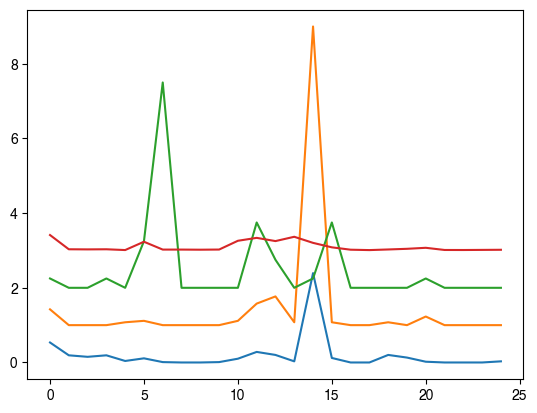

In [17]:
plt.plot(cm[-1].T + np.array([0, 1, 2, 3]));

### Clustering using k-means


In [18]:
def get_cluster_assignment(tvec, mvec):
    return np.argmin(np.linalg.norm(mvec - tvec, axis=1))

def get_cluster_mean(tokvec, clustassign):
    return np.array([np.mean(tokvec[clustassign == _c, :], axis=0)
                     for _c in np.unique(clustassign)])

def get_j_clust(tokvec, mvec, clustassign):
    return np.sum([np.sum(np.square(np.linalg.norm(tokvec[clustassign == _c, :] - mvec[_i, :], axis=1))) for _i, _c in enumerate(np.unique(clustassign))])


In [19]:
k = 3
# Random starting means.
mvec = tokvec[list(np.random.randint(0, tokvec.shape[0], k)), :]

# Cluster assingment for the random means.
clustassign = np.array([get_cluster_assignment(_tvec, mvec) for _tvec in tokvec])

# Compute J_clust
J_clust_curr = get_j_clust(tokvec, mvec, clustassign)

# Iterate now.
n_iter = 20
for i in range(n_iter):
    # Update the means.
    mvec = get_cluster_mean(tokvec, clustassign)
    
    # Update the cluster assignment.
    clustassign = np.array([get_cluster_assignment(_tvec, mvec) for _tvec in tokvec])
    
    # Update J_clust
    J_clust_prev = J_clust_curr
    J_clust_curr = get_j_clust(tokvec, mvec, clustassign)

    print(f"Iteration: {i:2d}, J_clust: {J_clust_curr:6.2f}, Change: {100 * (J_clust_curr - J_clust_prev) / J_clust_prev:.2f}%")

Iteration:  0, J_clust: 7467.56, Change: -8.29%
Iteration:  1, J_clust: 6945.21, Change: -6.99%
Iteration:  2, J_clust: 6646.57, Change: -4.30%
Iteration:  3, J_clust: 6266.99, Change: -5.71%
Iteration:  4, J_clust: 6200.14, Change: -1.07%
Iteration:  5, J_clust: 6066.19, Change: -2.16%
Iteration:  6, J_clust: 5973.34, Change: -1.53%
Iteration:  7, J_clust: 5909.82, Change: -1.06%
Iteration:  8, J_clust: 5811.22, Change: -1.67%
Iteration:  9, J_clust: 5684.04, Change: -2.19%
Iteration: 10, J_clust: 5609.77, Change: -1.31%
Iteration: 11, J_clust: 5544.07, Change: -1.17%
Iteration: 12, J_clust: 5543.29, Change: -0.01%
Iteration: 13, J_clust: 5543.29, Change: 0.00%
Iteration: 14, J_clust: 5543.29, Change: 0.00%
Iteration: 15, J_clust: 5543.29, Change: 0.00%
Iteration: 16, J_clust: 5543.29, Change: 0.00%
Iteration: 17, J_clust: 5543.29, Change: 0.00%
Iteration: 18, J_clust: 5543.29, Change: 0.00%
Iteration: 19, J_clust: 5543.29, Change: 0.00%


In [20]:
# Functions for performing k-means algorithm 
def get_cluster_assignment(tvec, mvec):
    return np.argmin(np.linalg.norm(mvec - tvec, axis=1))

def get_cluster_mean(tokvec, clustassign):
    return np.array([np.mean(tokvec[clustassign == _c, :], axis=0)
                     for _c in np.unique(clustassign)])

def get_j_clust(tokvec, mvec, clustassign):
    return np.sum([np.sum(np.square(np.linalg.norm(tokvec[clustassign == _c, :] - mvec[_i, :], axis=1))) for _i, _c in enumerate(np.unique(clustassign))])


### Demo of kmean class from chap01 module

In [21]:
# Generate sample data
_x1 = np.random.randn(100, 2) + np.array([4, 4])
_x2 = np.random.randn(100, 2)
X = np.vstack([_x1, _x2])
# Randomly reorder the rows
np.random.shuffle(X)

In [24]:
k=2
km = chap01.KMeans(X, 2)
cm, ca, j = km.fit()

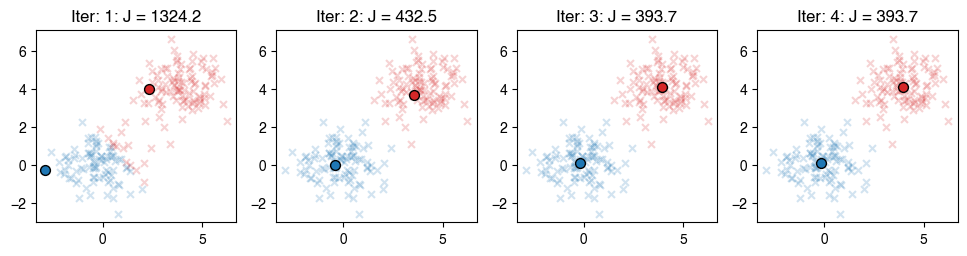

In [25]:
# Plot the k-mean algorithm evolution.
colors = ["tab:blue", "tab:red", "tab:green", "tab:orange", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
n = len(cm)
m = (n // 5) + 1
fig = plt.figure(figsize=(15, 2.5 * m))
for i in range(n):
    ax = fig.add_subplot(m, 5, i + 1)
    for _k in range(k):
        ax.scatter(X[ca[i] == _k, 0], X[ca[i] == _k, 1], s=25, color=colors[_k],
                   marker="x", alpha=0.2)
    for _k in range(k):
        ax.scatter(cm[i][_k, 0], cm[i][_k, 1], s=50, marker="o", alpha=1, 
                   color=colors[_k], edgecolors="black") 
    ax.set_title(f"Iter: {i + 1}: J = {j[i]:.1f}")

#### Similarity problem

In [58]:
X = np.array([
    [167, 102, 36.6],
    [180, 87, 26.9],
    [177, 78, 24.9],
    [152, 76, 32.9],
]).T

# Compute the distance between the points.
np.array([[np.linalg.norm(_v1 - _v2) for _v2 in X.T] for _v1 in X.T])

array([[ 0.        , 22.09275899, 28.51122586, 30.24384235],
       [22.09275899,  0.        ,  9.69535971, 30.6757233 ],
       [28.51122586,  9.69535971,  0.        , 26.32489316],
       [30.24384235, 30.6757233 , 26.32489316,  0.        ]])

In [59]:
X1 = X * np.array([0.01, 1, 1]).reshape(-1, 1)
# Compute the distance between the points.
np.array([[np.linalg.norm(_v1 - _v2) for _v2 in X1.T] for _v1 in X1.T])

array([[ 0.        , 17.86356347, 26.70018727, 26.26237803],
       [17.86356347,  0.        ,  9.21959327, 12.5330922 ],
       [26.70018727,  9.21959327,  0.        ,  8.25      ],
       [26.26237803, 12.5330922 ,  8.25      ,  0.        ]])

##### Angle similarity

In [60]:
def angle_between(v1, v2):
    return (180 / np.pi) * np.arccos(np.max([-1, np.min([1, np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))])]))

# Compute the distance between the points.
np.round(100 * np.array([[angle_between(_v1, _v2) for _v2 in X.T] for _v1 in X.T])) / 100

array([[0.  , 6.27, 8.21, 4.78],
       [6.27, 0.  , 2.02, 3.38],
       [8.21, 2.02, 0.  , 4.55],
       [4.78, 3.38, 4.55, 0.  ]])

In [61]:
# Compute the distance between the points.
np.round(100 * np.array([[angle_between(_v1, _v2) for _v2 in X1.T] for _v1 in X1.T])) / 100

array([[0.  , 2.57, 2.06, 3.67],
       [2.57, 0.  , 0.53, 6.23],
       [2.06, 0.53, 0.  , 5.7 ],
       [3.67, 6.23, 5.7 , 0.  ]])

In [63]:
X

array([[167. , 180. , 177. , 152. ],
       [102. ,  87. ,  78. ,  76. ],
       [ 36.6,  26.9,  24.9,  32.9]])

In [64]:
X1

array([[  1.67,   1.8 ,   1.77,   1.52],
       [102.  ,  87.  ,  78.  ,  76.  ],
       [ 36.6 ,  26.9 ,  24.9 ,  32.9 ]])

In [66]:
np.round(100 * np.array([v / np.linalg.norm(v) for v in X.T]).T) / 100

array([[0.84, 0.89, 0.91, 0.88],
       [0.51, 0.43, 0.4 , 0.44],
       [0.18, 0.13, 0.13, 0.19]])

In [67]:
np.round(100 * np.array([v / np.linalg.norm(v) for v in X1.T]).T) / 100

array([[0.02, 0.02, 0.02, 0.02],
       [0.94, 0.96, 0.95, 0.92],
       [0.34, 0.3 , 0.3 , 0.4 ]])